Import some libraries we'll use:

In [12]:
import urllib.request
import gzip
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt

%matplotlib inline

# Get stations

First, let's get the list of stations so that we have a lat/lon location for each:

In [2]:
stations = pd.read_fwf("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt", 
            infer_nrows=300, # how many rows to use to infer the column widths
            usecols = [0,1,2,3,4],
            names = ["station", "lat", "lon", "elevation", "name"])

stations.head()

,station,lat,lon,elevation,name
0,ACW00011604,17.1167,-61.7833,10.1,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN
3,AEM00041194,25.2550,55.3640,10.4,NaN
4,AEM00041217,24.4330,54.6510,26.8,NaN


Pull out the country ID from the station column (first two letters):

In [3]:
stations["country"] = stations["station"].astype(str).str[0:2]
stations.head()

,station,lat,lon,elevation,name,country
0,ACW00011604,17.1167,-61.7833,10.1,NaN,AC
1,ACW00011647,17.1333,-61.7833,19.2,NaN,AC
2,AE000041196,25.3330,55.5170,34.0,NaN,AE
3,AEM00041194,25.2550,55.3640,10.4,NaN,AE
4,AEM00041217,24.4330,54.6510,26.8,NaN,AE


Sanity ceck: Quick density plot of the stations

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-179.983  , -176.38997, -172.79694, -169.20391, -165.61088,
        -162.01785, -158.42482, -154.83179, -151.23876, -147.64573,
        -144.0527 , -140.45967, -136.86664, -133.27361, -129.68058,
        -126.08755, -122.49452, -118.90149, -115.30846, -111.71543,
        -108.1224 , -104.52937, -100.93634,  -97.34331,  -93.75028,
         -90.15725,  -86.56422,  -82.97119,  -79.37816,  -75.78513,
         -72.1921 ,  -68.59907,  -65.00604,  -61.41301,  -57.81998,
         -54.22695,  -50.63392,  -47.04089,  -43.44786,  -39.85483,
         -36.2618 ,  -32.66877,  -29.07574,  -25.48271,  -21.88968,
         -18.29665,  -14.70362,  -11.11059,   -7.51756,   -3.92453,
          -0.3315 ,    3.26153,    6.85456,   10.44759,   14.04062,
   

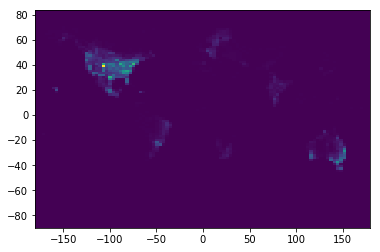

In [9]:
plt.hist2d(stations["lon"], stations["lat"], bins=100)

Only the US:

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-178.0333  , -174.460134, -170.886968, -167.313802, -163.740636,
        -160.16747 , -156.594304, -153.021138, -149.447972, -145.874806,
        -142.30164 , -138.728474, -135.155308, -131.582142, -128.008976,
        -124.43581 , -120.862644, -117.289478, -113.716312, -110.143146,
        -106.56998 , -102.996814,  -99.423648,  -95.850482,  -92.277316,
         -88.70415 ,  -85.130984,  -81.557818,  -77.984652,  -74.411486,
         -70.83832 ,  -67.265154,  -63.691988,  -60.118822,  -56.545656,
         -52.97249 ,  -49.399324,  -45.826158,  -42.252992,  -38.679826,
         -35.10666 ,  -31.533494,  -27.960328,  -24.387162,  -20.813996,
         -17.24083 ,  -13.667664,  -10.094498,   -6.521332,   -2.948166,
           0.625   , 

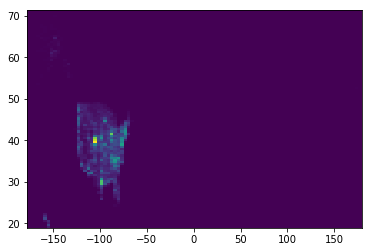

In [10]:
stations_US = stations[stations["country"] == "US"]
plt.hist2d(stations_US["lon"], stations_US["lat"], bins=100)

### 🔥 THERE IS SOMETHING WRONG WITH THE STATION DATA, NEED TO CHECK WHY NO STATIONS WEST OF CA. 120 DEG. WEST

... let's ignore that for now and continue:


# Get [GHSL population data](https://ghsl.jrc.ec.europa.eu/ghs_pop.php) for 1975

Download dir at http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/

In [13]:
file = 'GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip'
if os.path.isfile(file):
    print(file, 'already downloaded.')
else:
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW41975_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file)
    
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

# Get NOAA NCDC data

Download the data from NOAA. The columns in the file are documented [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/readme.txt).

In [ ]:
file = '1975.csv.gz'
if os.path.isfile(file):
    print(file, 'already downloaded.')
else:
    urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/1975.csv.gz', file)

Before we can read the file, we'll define our own date parser:

In [ ]:
noaadateparser = lambda x: pd.datetime.strptime(x, "%Y%m%d")


Unzip the file and load the CSV with pandas, using our date parser. We'll also give the columns names since the CSV doesn't have a header 🧟‍:

In [ ]:
with gzip.open('1975.csv.gz') as f:

    data_1975 = pd.read_csv(f, 
                            names = ["station", "date", "type", "value"],
                            usecols = [0,1,2,3],
                            parse_dates = ["date"],
                            date_parser = noaadateparser)

data_1975.head()

In [ ]:
data_1975.dtypes

Only keep TMIN and TMAX:

In [ ]:
data_1975 = data_1975[(data_1975["type"] == "TMAX") | (data_1975["type"] == "TMIN")] 

In [ ]:
data_1975.head

Join the two together:

In [ ]:
data_1975 = pd.merge(data_1975, stations, on="station")
data_1975.head()



Index the dataframe by country, station, date and observation type:

In [ ]:
data_1975.set_index(['country','station','date','type'], inplace=True)
data_1975.head()

In [ ]:
data_1975.loc['US']